## Fair PCA Implementation + evalutation on transformed dataset

In [88]:
import pandas as pd
import seaborn as sns
# import random forest from sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score
import matplotlib.pyplot as plt

from scipy.linalg import null_space

from sklearn.decomposition import PCA as SklearnPCA
from scipy.linalg import null_space
import numpy as np



In [89]:

def preprocess_and_split_data(df):
    # Define features and target
    features = df.drop('pass_bar', axis=1)  # Drop the target column to get features
    target = df['pass_bar']

    # Define groups (race and gender)
    groups = df[['race1_asian', 'race1_black', 'race1_hisp', 'race1_other', 'race1_white', 'gender']]

    # Drop unnecessary columns from features
    features = features.drop(['race1_asian', 'race1_black', 'race1_hisp', 'race1_other', 'race1_white', 'gender'], axis=1)

    # Preserve indices before splitting
    indices = features.index

    # Split data into train and test sets
    X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(
        features, target, groups, test_size=0.2, random_state=0, shuffle=True
    )

    # Preserve indices in the split data
    X_train_index = X_train.index
    X_test_index = X_test.index

    return X_train, X_test, y_train, y_test, group_train, group_test, X_train_index, X_test_index

# Load the data
df = pd.read_csv('data/non_scaled_data.csv')

# Preprocess and split data
X_train, X_test, y_train, y_test, group_train, group_test, X_train_index, X_test_index = preprocess_and_split_data(df)


# Printing the shapes of the train and test sets
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)
print("group_train shape:", group_train.shape)
print("group_test shape:", group_test.shape)


X_train shape: (17925, 10)
X_test shape: (4482, 10)
y_train shape: (17925,)
y_test shape: (4482,)
group_train shape: (17925, 6)
group_test shape: (4482, 6)


In [90]:


def PCA(X_train, n_components):
    """ Implements sci-kit's version of basic PCA and returns sorted eigenvectors"""
    
    pca = SklearnPCA(n_components=n_components)
    X_PCA = pca.fit_transform(X_train)
    
    # Get the sorted eigenvalues and eigenvectors
    eigenvalues = pca.explained_variance_
    eigenvectors = pca.components_
    
    # Sort eigenvectors based on eigenvalues
    sorted_indices = np.argsort(eigenvalues)[::-1]  # Reverse order to get descending
    sorted_eig_vectors = eigenvectors[sorted_indices]
    
    return X_PCA, sorted_eig_vectors



def fair_PCA(X_train, groups):

    """Implements fair PCA"""

    #z = groups.astype(int)
    X = X_train
    Z = groups.astype(int)
 
    # Compute null space
    R = null_space(np.dot(Z.T, X))

    RTXXR = R.T @ X.T @ X @ R

    # Get eigenvalues and vectors
    eig_vals, eig_vectors = np.linalg.eig(RTXXR)

    # Sort to find the largest eigenvectors
    idxs = np.argsort(eig_vals)[::-1]
    sorted_eig_vectors = eig_vectors[:, idxs]
    top_k_eig_vectors = sorted_eig_vectors[:, :57]

    # Build matrix A which has the eigenvectors as columns
    A = top_k_eig_vectors
    
    # Multiply A with the null space
    U = R @ A

    # Return the reprocejted data
    X_fair_PCA = X_train @ U

    
    return X_fair_PCA, U

In [91]:

def corr_plot(X_train, groups, n_components=4, fair=True):
    """Plots the correlation between PCA components and protected features"""
    
    protected_features = groups 
    fig, axes = plt.subplots(figsize=(25, 5))

    if fair:
        # Get the fairPCA transformed data
        X_PCA_n, U = fair_PCA(X_train, groups)
    else:
        # Get the PCA transformed data
        X_PCA_n, sorted_eigen = PCA(X_train, n_components)

    protected_features = protected_features.astype(int)


    # Compute correlation between PCA components and protected features
    corr_matrix = np.corrcoef(np.column_stack((protected_features, X_PCA_n)).T)

    # Display only the correlation between PCA components and protected features
    corr_matrix = np.nan_to_num(corr_matrix[:protected_features.shape[1], protected_features.shape[1]:], nan=0.0)

    # Determine the range for x-axis labels based on the length of corr_matrix
    x_labels_range = range(1, corr_matrix.shape[1] + 1)

    sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", center=0, vmin=-.1, vmax=.1, square=True, ax=axes, fmt=".2f")
    if fair:
        axes.set_xticklabels(x_labels_range)
        axes.set_title(f"Corr between Fair PCA and Prot. features")
    else:
        axes.set_xticklabels(x_labels_range)
        axes.set_title(f"Corr between PCA and Prot. features")

    axes.set_yticklabels(['Asian', 'Black', 'Hispanic', 'Other', 'White','Gender'], va='center')
    axes.set_xlabel("Component")
    axes.set_ylabel("Protected Feature (Subgroup)")

    plt.tight_layout()
    plt.show()


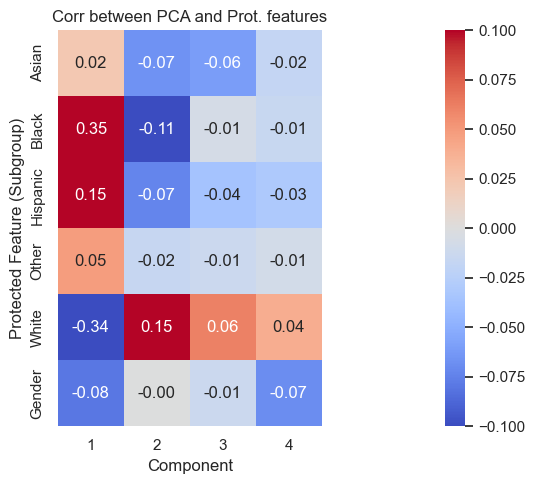

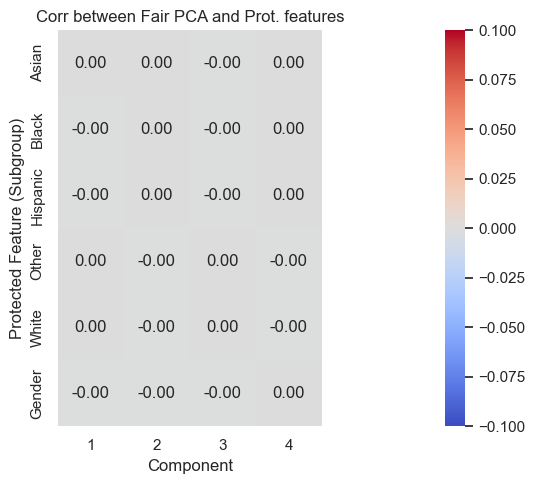

In [92]:
corr_plot(X_train, group_train, fair=False)
corr_plot(X_train, group_train, fair=True)

## Random Forest using fairPCA transformed data and standard PCA transformed data

Importing non scaled data which will be used for finding the indeces of each gender/race group

In [93]:

# Preprocess and split non-scaled data
#X_train_non_scaled, X_test_non_scaled, y_train_non_scaled, y_test_non_scaled, group_train_non_scaled, group_test_non_scaled, X_train_index_non_scaled, X_test_index_non_scaled = preprocess_and_split_data(df, scale=False)

# Getting debiased data using PCA
X_train_fair_PCA, U = fair_PCA(X_train, group_train)
X_test_fair_PCA = X_test @ U

# Convert back to DataFrame and preserve indices
X_train_fair_PCA = pd.DataFrame(X_train_fair_PCA, index=X_train_index)
X_test_fair_PCA = pd.DataFrame(X_test_fair_PCA, index=X_test_index)

# Save X_train_PCA and X_test_PCA to CSV
X_train_fair_PCA.to_csv('data/X_train_fair_PCA.csv', index=True)
X_test_fair_PCA.to_csv('data/X_test_fair_PCA.csv', index=True)


# Save merged df to csv to use in shap analysis in other notebook to preserve the indices
merged_X_train = pd.merge(X_train, group_train, left_index=True, right_index=True)
merged_X_test = pd.merge(X_test, group_test, left_index=True, right_index=True)


merged_X_train.to_csv('data/X_train.csv', index=True)
merged_X_test.to_csv('data/X_test.csv', index=True)
y_train.to_csv('data/y_train.csv')
y_test.to_csv('data/y_test.csv')

In [94]:

# Random Forest model on debiased data
rf_fair_pca = RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_leaf=25, random_state=42, class_weight='balanced')
rf_fair_pca.fit(X_train_fair_PCA, y_train)
y_pred_fair_pca_rf = rf_fair_pca.predict(X_test_fair_PCA)

# Calculate accuracy and F1 score
accuracy_fair_pca_rf = accuracy_score(y_test, y_pred_fair_pca_rf)
f1_fair_pca_rf = f1_score(y_test, y_pred_fair_pca_rf)

# Calculate the confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_fair_pca_rf).ravel()

# Calculate the false negative rate (FNR)
fnr_fair_pca_rf = fn / (fn + tp)

# Print results
print(f"Accuracy (Random Forest on debiased data): {accuracy_fair_pca_rf}")
print(f"F1 Score (Random Forest on debiased data): {f1_fair_pca_rf}")
print(f"False Negative Rate (Random Forest on debiased data): {fnr_fair_pca_rf}")




Accuracy (Random Forest on debiased data): 0.7896028558679161
F1 Score (Random Forest on debiased data): 0.8791490452390106
False Negative Rate (Random Forest on debiased data): 0.19103773584905662


In [155]:

def evaluate_race_performance(model, X_test, y_test, group_test_non_scaled, column, flag):

    # Extract the column as a numpy array
    values = group_test_non_scaled[column].values

    if column == 'gender' and flag == 'Male':
        # Find male indeces
        X_test = X_test[values == 1]
        y_test = y_test[values == 1]

    elif column == 'gender' and flag == 'Female':
        # Find female indeces
        X_test = X_test[values == 0]
        y_test = y_test[values == 0]
    
    else:
        # find specific race indeces
        X_test = X_test[values == 1]
        y_test = y_test[values == 1]
        
    # Predict labels for the specific race/gender
    y_pred = model.predict(X_test)
    
    # Calculate accuracy for the specific race/hgender
    accuracy = accuracy_score(y_test, y_pred)
    
    # Calculate the confusion matrix for the specific race/gender
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    
    # Calculate the false negative rate (FNR) for the specific race/gender
    fnr = fn / (fn + tp) if (fn + tp) > 0 else 0  # Handle division by zero
    
    return accuracy, fnr

# List of columns to evaluate
columns = ['race1_asian', 'race1_black', 'race1_hisp', 'race1_white','race1_other', 'gender', 'gender']

# Initialize an empty list to store results
results = []


flag = 'Male'
for column in columns:
    accuracy, fnr = evaluate_race_performance(
        rf_fair_pca, 
        X_test_fair_PCA, 
        y_test, 
        group_test, 
        column,
        flag
    )



    # Print the results
    if column == 'gender':
        # Append the results to the list
        results.append({
        'Column': column,
        'Accuracy': accuracy,
        'FNR': fnr,
        'Gender': flag
        })

        print(f"Accuracy for {column, flag}: {accuracy:.4f}")
        print(f"False Negative Rate for {column, flag}: {fnr:.4f}")
        print()
        flag = 'Female'

    else:
        # Append the results to the list
        results.append({
        'Column': column,
        'Accuracy': accuracy,
        'FNR': fnr,
        'Gender': 'NA'
        })

        print(f"Accuracy for {column}: {accuracy:.4f}")
        print(f"False Negative Rate for {column}: {fnr:.4f}")
        print()

Accuracy for race1_asian: 0.7198
False Negative Rate for race1_asian: 0.2455

Accuracy for race1_black: 0.6549
False Negative Rate for race1_black: 0.2474

Accuracy for race1_hisp: 0.7273
False Negative Rate for race1_hisp: 0.2035

Accuracy for race1_white: 0.8069
False Negative Rate for race1_white: 0.1843

Accuracy for race1_other: 0.7083
False Negative Rate for race1_other: 0.2344

Accuracy for ('gender', 'Male'): 0.7887
False Negative Rate for ('gender', 'Male'): 0.1929

Accuracy for ('gender', 'Female'): 0.7908
False Negative Rate for ('gender', 'Female'): 0.1886



### Standard PCA reprojected data

In [157]:
from sklearn.decomposition import PCA

def train_random_forest_with_pca(X_train, y_train, X_test, y_test, n_components=10, n_estimators=100, max_depth=10, min_samples_leaf=25, class_weight='balanced'):
    # PCA Transformation
    pca = PCA(n_components=n_components)
    X_PCA_train = pca.fit_transform(X_train)
    X_test_PCA = pca.transform(X_test)
    
    # Random Forest model on PCA data
    rf_pca = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_leaf=min_samples_leaf,
        random_state=42,
        class_weight=class_weight
    )
    rf_pca.fit(X_PCA_train, y_train)
    y_pred_pca_rf = rf_pca.predict(X_test_PCA)
    
    # Calculate accuracy and F1 score
    accuracy_pca_rf = accuracy_score(y_test, y_pred_pca_rf)
    f1_pca_rf = f1_score(y_test, y_pred_pca_rf)
    
    # Calculate the confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_pca_rf).ravel()
    
    # Calculate the false negative rate (FNR)
    fnr_pca_rf = fn / (fn + tp) if (fn + tp) > 0 else float('nan')  # Avoid division by zero
    
    # Print results
    print(f"Accuracy (Random Forest on PCA data): {accuracy_pca_rf:.4f}")
    print(f"F1 Score (Random Forest on PCA data): {f1_pca_rf:.4f}")
    print(f"False Negative Rate (Random Forest on PCA data): {fnr_pca_rf:.4f}")
    print()
    
    # Return the model and PCA-transformed test data
    return rf_pca, X_test_PCA



rf_model_pca, X_test_PCA_transformed = train_random_forest_with_pca(
    X_train, y_train, X_test, y_test, 
    n_components=10, 
    n_estimators=100, 
    max_depth=10, 
    min_samples_leaf=25, 
    class_weight='balanced'
)

 

# List of columns to evaluate
columns = ['race1_asian', 'race1_black', 'race1_hisp', 'race1_white','race1_other', 'gender', 'gender']

# Initialize an empty list to store results
results_pca = []


flag = 'Male'
for column in columns:
    accuracy, fnr = evaluate_race_performance(
        rf_model_pca, 
        X_test_PCA_transformed, 
        y_test, 
        group_test, 
        column,
        flag
    )


    # Print the results
    if column == 'gender':
        # Append the results to the list
        results_pca.append({
        'Column': column,
        'Accuracy': accuracy,
        'FNR': fnr,
        'Gender': flag 
        })


        print(f"Accuracy for {column, flag}: {accuracy:.4f}")
        print(f"False Negative Rate for {column, flag}: {fnr:.4f}")
        print()
        flag = 'Female'


    else:

        # Append the results to the list
        results_pca.append({
        'Column': column,
        'Accuracy': accuracy,
        'FNR': fnr,
        'Gender': 'NA'
        })

        print(f"Accuracy for {column}: {accuracy:.4f}")
        print(f"False Negative Rate for {column}: {fnr:.4f}")
        print()

Accuracy (Random Forest on PCA data): 0.8541
F1 Score (Random Forest on PCA data): 0.9181
False Negative Rate (Random Forest on PCA data): 0.1354

Accuracy for race1_asian: 0.7802
False Negative Rate for race1_asian: 0.2156

Accuracy for race1_black: 0.4980
False Negative Rate for race1_black: 0.6474

Accuracy for race1_hisp: 0.6869
False Negative Rate for race1_hisp: 0.3081

Accuracy for race1_white: 0.8914
False Negative Rate for race1_white: 0.0960

Accuracy for race1_other: 0.8056
False Negative Rate for race1_other: 0.1875

Accuracy for ('gender', 'Male'): 0.8524
False Negative Rate for ('gender', 'Male'): 0.1375

Accuracy for ('gender', 'Female'): 0.8563
False Negative Rate for ('gender', 'Female'): 0.1326



### Comparison of FNR and accuracy score for baseline model and FairPCA model for the race attribute 

In [158]:
# Reading in the baseline results which are computed in the "baseline_evaluations.ipynb" notebook
baselines_results = pd.read_csv('data/results_baseline.csv')
results_baseline_df = baselines_results[baselines_results['Attribute'] != 'gender']


# Convert results to DataFrames
results_df = pd.DataFrame(results)
results_pca_df = pd.DataFrame(results_pca)


# Map race columns to readable names
race1_map = {
    'race1_asian': 'Asian',
    'race1_black': 'Black',
    'race1_hisp': 'Hisp',
    'race1_other': 'Other',
    'race1_white': 'White'
}

# Add a new column with readable race names if necessary
if 'Race Name' not in results_df.columns:
    results_df['Race Name'] = results_df['Column'].map(race1_map)
    results_pca_df['Race Name'] = results_pca_df['Column'].map(race1_map)

results_df = results_df[results_df['Column'] != 'gender']


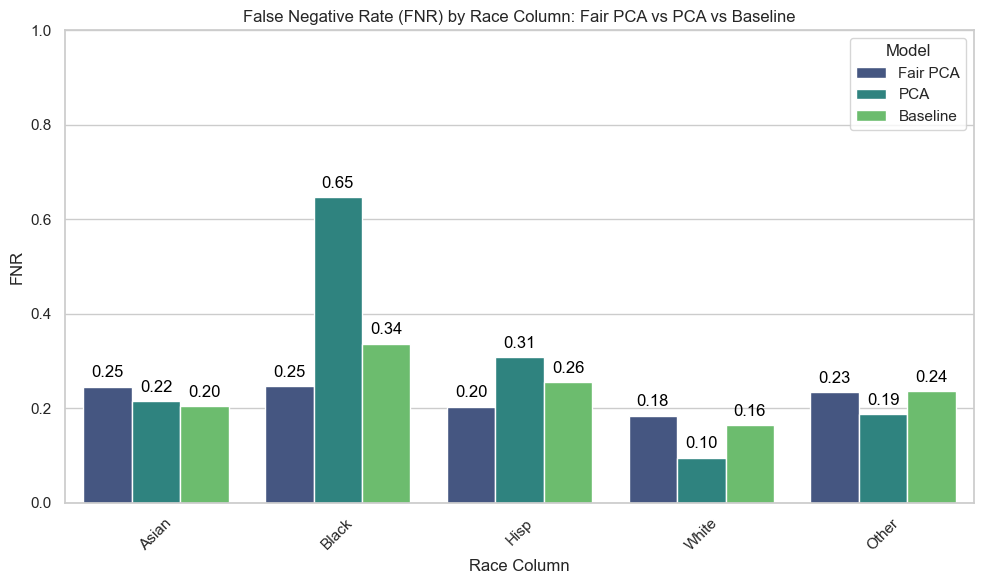

In [159]:


if 'Group' not in results_baseline_df.columns:
    results_baseline_df['Group'] = results_baseline_df['Attribute'].map(race1_map)

# Ensure the column names are consistent for merging
results_baseline_df = results_baseline_df.rename(columns={'Attribute': 'Race Column', 'Group': 'Race Name'})

# Add a new column to distinguish between the two datasets
results_df['Model'] = 'Fair PCA'
results_pca_df['Model'] = 'PCA'
results_baseline_df['Model'] = 'Baseline'

# Concatenate the two DataFrames
combined_df = pd.concat([results_df[['Column', 'FNR', 'Accuracy','Race Name', 'Model']],results_pca_df[['Column', 'FNR', 'Accuracy', 'Race Name', 'Model']],  results_baseline_df[['Race Column', 'FNR', 'Accuracy', 'Race Name', 'Model']]])

# Drop rows where 'Race Name' is NaN
combined_df = combined_df.dropna(subset=['Race Name'])

# Reset index to ensure unique index
combined_df = combined_df.reset_index(drop=True)

# Set plot style
sns.set(style="whitegrid")

# Create a bar plot for FNR
plt.figure(figsize=(10, 6))
barplot = sns.barplot(x='Race Name', y='FNR', hue='Model', data=combined_df, palette="viridis")

# Set plot titles and labels
plt.title('False Negative Rate (FNR) by Race: Fair PCA vs PCA vs Baseline')
plt.xlabel('Race')
plt.ylabel('FNR')
plt.ylim(0, 1)  # Set y-axis limit from 0 to 1
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

# Annotate FNR scores on bars
for p in barplot.patches:
    height = p.get_height()
    if height > 0:  # Only annotate bars with a height greater than 0
        barplot.annotate(f'{height:.2f}', 
                         (p.get_x() + p.get_width() / 2., height), 
                         ha='center', va='center', 
                         xytext=(0, 10), 
                         textcoords='offset points', 
                         color='black')

# Display the plot
plt.tight_layout()
plt.show()


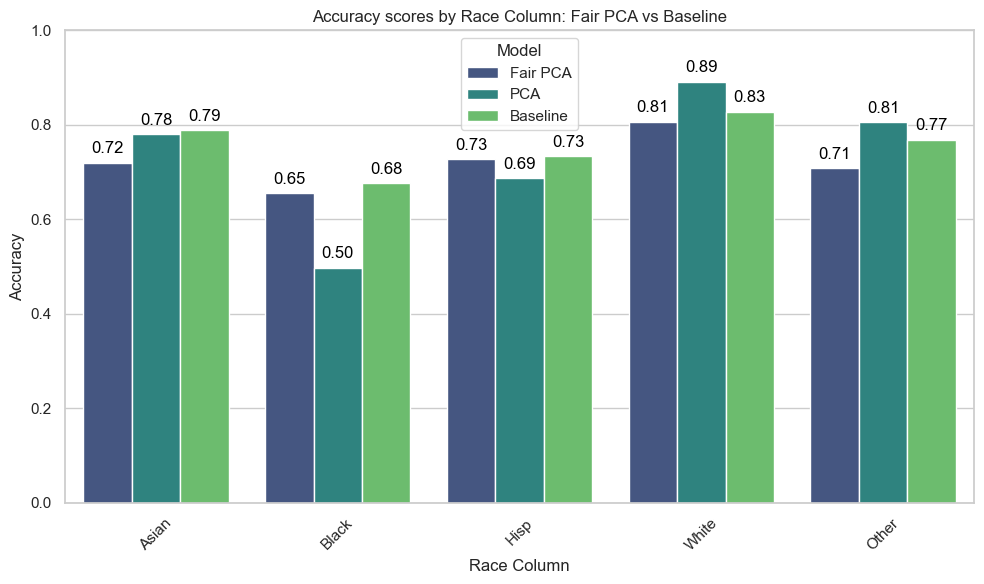

In [160]:

# Set plot style
sns.set(style="whitegrid")

# Create a bar plot for Accuracy
plt.figure(figsize=(10, 6))
barplot = sns.barplot(x='Race Name', y='Accuracy', hue='Model', data=combined_df, palette="viridis")

# Set plot titles and labels
plt.title('Accuracy scores by Race: Fair PCA vs Baseline')
plt.xlabel('Race')
plt.ylabel('Accuracy')
plt.ylim(0, 1)  # Set y-axis limit from 0 to 1
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

# Annotate Accuracy scores on bars
for p in barplot.patches:
    height = p.get_height()
    if height > 0:  # Only annotate bars with a height greater than 0
        barplot.annotate(f'{height:.2f}', 
                         (p.get_x() + p.get_width() / 2., height), 
                         ha='center', va='center', 
                         xytext=(0, 10), 
                         textcoords='offset points', 
                         color='black')

# Display the plot
plt.tight_layout()
plt.show()


### Evaluations for gender

##### preprocessing

In [161]:
# Reading in the baseline results which are computed in the "baseline_evaluations.ipynb" notebook
baselines_results = pd.read_csv('data/results_baseline.csv')
results_baseline_df = baselines_results[baselines_results['Attribute'] == 'gender']


# Convert results to DataFrames
results_df = pd.DataFrame(results)
results_pca_df = pd.DataFrame(results_pca)



results_df = results_df[results_df['Column'] == 'gender']

results_pca_df = results_pca_df[results_pca_df['Column'] == 'gender']


##### Plot for FNR among the gender group

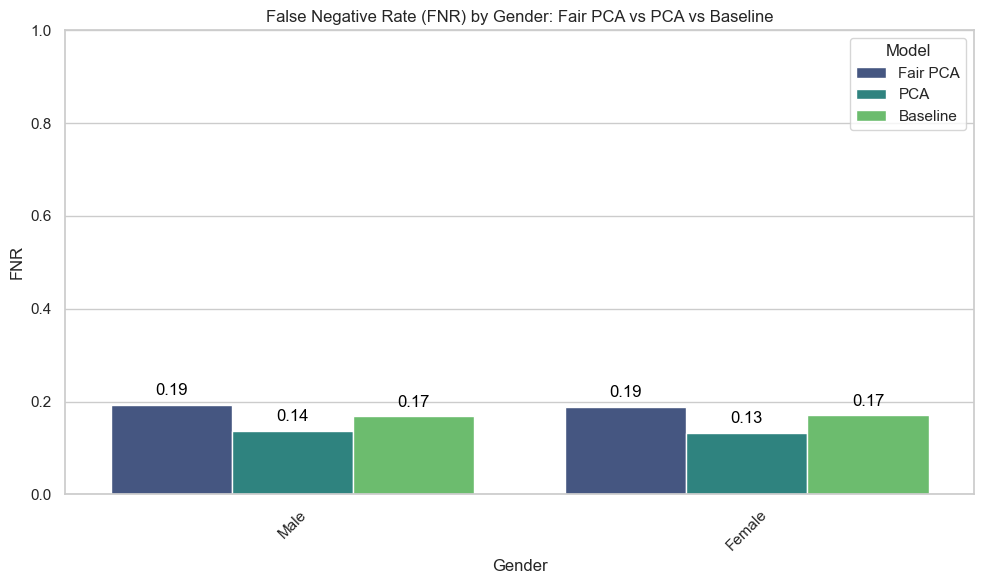

In [177]:


# Ensure the column names are consistent for merging 
results_baseline_df = results_baseline_df.rename(columns={'Group': 'Gender', 'Attribute': 'Column'})

# Add a new column to distinguish between the two datasets
results_df['Model'] = 'Fair PCA'
results_pca_df['Model'] = 'PCA'
results_baseline_df['Model'] = 'Baseline'

# Concatenate the two DataFrames
combined_df = pd.concat([results_df[['Column', 'FNR', 'Accuracy','Gender', 'Model']],results_pca_df[['Column', 'FNR', 'Accuracy', 'Gender', 'Model']],  results_baseline_df[['Column', 'FNR', 'Accuracy', 'Gender', 'Model']]])

# Reset index to ensure unique index
combined_df = combined_df.reset_index(drop=True)

# Set plot style
sns.set(style="whitegrid")

# Create a bar plot for FNR
plt.figure(figsize=(10, 6))
barplot = sns.barplot(x='Gender', y='FNR', hue='Model', data=combined_df, palette="viridis")

# Set plot titles and labels
plt.title('False Negative Rate (FNR) by Gender: Fair PCA vs PCA vs Baseline')
plt.xlabel('Gender')
plt.ylabel('FNR')
plt.ylim(0, 1)  # Set y-axis limit from 0 to 1
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

# Annotate FNR scores on bars
for p in barplot.patches:
    height = p.get_height()
    if height > 0:  # Only annotate bars with a height greater than 0
        barplot.annotate(f'{height:.2f}', 
                         (p.get_x() + p.get_width() / 2., height), 
                         ha='center', va='center', 
                         xytext=(0, 10), 
                         textcoords='offset points', 
                         color='black')

# Display the plot
plt.tight_layout()
plt.show()


##### Plot for accuracy among the gender group

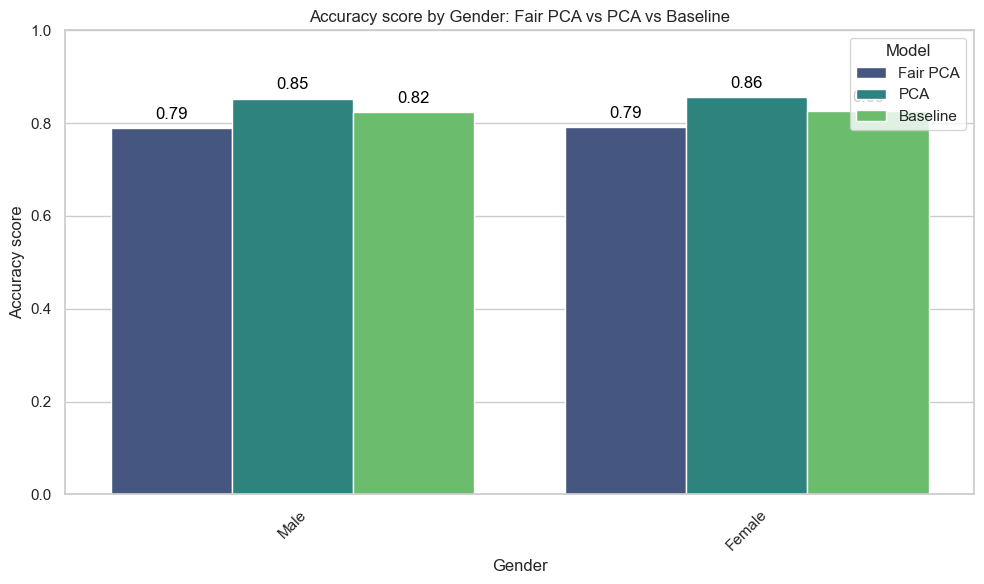

In [179]:


# Ensure the column names are consistent for merging 
results_baseline_df = results_baseline_df.rename(columns={'Group': 'Gender', 'Attribute': 'Column'})

# Add a new column to distinguish between the two datasets
results_df['Model'] = 'Fair PCA'
results_pca_df['Model'] = 'PCA'
results_baseline_df['Model'] = 'Baseline'

# Concatenate the two DataFrames
combined_df = pd.concat([results_df[['Column', 'FNR', 'Accuracy','Gender', 'Model']],results_pca_df[['Column', 'FNR', 'Accuracy', 'Gender', 'Model']],  results_baseline_df[['Column', 'FNR', 'Accuracy', 'Gender', 'Model']]])

# Reset index to ensure unique index
combined_df = combined_df.reset_index(drop=True)

# Set plot style
sns.set(style="whitegrid")

# Create a bar plot for FNR
plt.figure(figsize=(10, 6))
barplot = sns.barplot(x='Gender', y='Accuracy', hue='Model', data=combined_df, palette="viridis")

# Set plot titles and labels
plt.title('Accuracy score by Gender: Fair PCA vs PCA vs Baseline')
plt.xlabel('Gender')
plt.ylabel('Accuracy score')
plt.ylim(0, 1)  # Set y-axis limit from 0 to 1
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

# Annotate Accuracy scores on bars
for p in barplot.patches:
    height = p.get_height()
    if height > 0:  # Only annotate bars with a height greater than 0
        barplot.annotate(f'{height:.2f}', 
                         (p.get_x() + p.get_width() / 2., height), 
                         ha='center', va='center', 
                         xytext=(0, 10), 
                         textcoords='offset points', 
                         color='black')

# Display the plot
plt.tight_layout()
plt.show()
